# 프로젝트 : SentencePiece 사용하기
# Step1. Import Library

In [ ]:
# Mecab 설치
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [6]:
from konlpy.tag import Mecab
import pandas as pd
import numpy as np
import re
from tensorflow import keras
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step2. Import Data
사용할 데이터셋은 [네이버 영화리뷰 감정분석](https://github.com/e9t/nsmc/)입니다.

In [7]:
train_data = pd.read_table('/content/drive/MyDrive/GoingDeeper_Data/GD1/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/GoingDeeper_Data/GD1/ratings_test.txt')

train_data.sample(5)

,id,document,label
65668,8558886,저 브로커조차 돈을받고 다큐를 찍었네ㅋ,0
136490,2050923,2004년 최악의 영화중 하나.,0
52019,1371995,내가본 최고의 영화중 한편으로 각인될것이다.,1
77908,9766503,줄리안이다ㅋㅋ 요래보니 반갑군ㅋㅋ,1
52586,3719672,세상에서 가장 똑똑해 보이는 멍청이의 요절복통 코메디,1


# Step3. Preprocessing Data

## 1. 전처리함수 구현
해당 데이터는 전처리가 되지 않은 데이터입니다. 전처리함수를 만들고, 함수를 이용해 전처리를 시켜주겠습니다. 그리고 토크나이저는 Mecab, Kkma, Okt 3가지를 사용할 것인데 먼저 Mecab으로 수행해보겠습니다.

In [ ]:
tokenizer = Mecab()

In [8]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def preprocessing(train_data, test_data, num_words=10000):
    # 중복치, 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how= 'any')
    test_data = test_data.dropna(how= 'any')

    # 토큰화, 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X) # 리스트안에 리스트로 저장됨

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)

    # 사전구성
    words = np.concatenate(X_train).tolist() # 각 리스트들을 합쳐주면 넘파이배열로 저장되는데 이를 다시 리스트로변환
    counter = Counter(words) # 딕셔너리형태로 각 단어의 빈도수를 저장
    counter = counter.most_common(10000-4) # 각 단어의 빈도수를 튜플로만들고 내림차순으로 리스트에 담음
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] # 빈도수를 제외하고 각 단어들을 특수토큰과 합침
    word_to_index = {word:index for index, word in enumerate(vocab)} # 리스트에 담겨있는 단어 순서대로 0부터 인덱스를 매김

    # 텍스트리스트를 꺼내서 이를 각 단어에해당하는 인덱스 리스트로 변환시켜줌
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    # X_train, y_train, X_test, y_test, word_to_index 리턴턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [ ]:
X_train, y_train, X_test, y_test, word_to_index = preprocessing(train_data, test_data)

In [ ]:
index_to_word = {index:word for word, index in word_to_index.items()}

## 2. 패딩
패딩을 시켜주기위해 먼저 데이터셋 내 문장 길이 분포를 확인하고 최대길이를 지정해주겠습니다.

In [ ]:
total_data = list(X_train) + list(X_test)
len_list = [len(sentence) for sentence in total_data] # 문장길이 리스트

(array([3.5740e+03, 2.1467e+04, 3.6004e+04, 3.0725e+04, 2.5049e+04,
        2.0522e+04, 1.4715e+04, 9.5350e+03, 5.9230e+03, 2.8880e+03,
        3.6190e+03, 2.9720e+03, 2.5950e+03, 2.2050e+03, 1.9180e+03,
        1.7100e+03, 1.6030e+03, 1.6800e+03, 1.7670e+03, 1.1360e+03,
        1.4320e+03, 1.0730e+03, 6.1800e+02, 3.1700e+02, 1.6000e+02,
        6.7000e+01, 3.8000e+01, 1.3000e+01, 4.0000e+00, 3.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  0. ,   2.9,   5.8,   8.7,  11.6,  14.5,  17.4,  20.3,  23.2,
         26.1,  29. ,  31.9,  34.8,  37.7,  40.6,  43.5,  46.4,  49.3,
         52.2,  55.1,  58. ,  60.9,  63.8,  66.7,  69.6,  72.5,  75.4,
         78.3,  81.2,  84.1,  87. ,  89.9,  92.8,  95.7,  98.6, 101.5,
        104.4, 107.3, 110.2, 113.1, 116. ]),
 <a list of 40 Patch objects>)

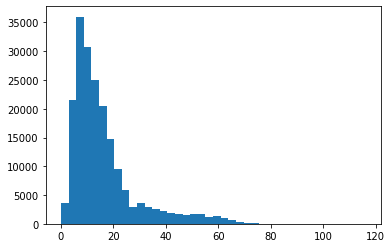

In [ ]:
plt.hist(len_list, bins=40)

최대길이는 평균에다가 표준편차*2를 더한값으로 하겠습니다.(신뢰구간95%)

In [ ]:
max_len = np.mean(len_list) + 2 * np.std(len_list)
max_len = int(max_len)
print(max_len)

41


이제 패딩을 시켜줍시다.

In [ ]:
X_train = pad_sequences(X_train,
                        value=word_to_index["<PAD>"],
                        padding='pre',
                        maxlen=max_len)
X_test = pad_sequences(X_test,
                       value=word_to_index["<PAD>"],
                       padding='pre',
                       maxlen=max_len)

# Step4. 모델 생성 및 훈련
## LSTM
모델을 설계해봅시다.

In [ ]:
vocab_size = 10000
word_vector_dim = 200

lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         2000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 6688      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


훈련을 시켜보겠습니다

In [ ]:
epochs = 20
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=0)

lstm.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

lstm.fit(X_train, y_train,
         epochs=epochs,
         batch_size=512,
         validation_data=(X_test, y_test),
         callbacks=[callback],
         verbose=1)

Epoch 1/20
286/286 [==============================] - 5s 9ms/step - loss: 0.4389 - accuracy: 0.8043 - val_loss: 0.3575 - val_accuracy: 0.8454
Epoch 2/20
286/286 [==============================] - 2s 8ms/step - loss: 0.3191 - accuracy: 0.8647 - val_loss: 0.3434 - val_accuracy: 0.8502


# Step5. 다른 토크나이저들(KoNLPy)
## Kkma
이번엔 Kkma를 토크나이저로 사용해보겠습니다.

그냥 Konlpy를 install하면 Kkma와 Okt사용에는 문제가 없고, Mecab사용할때 문제가 발생한다. 그래서 초반에 Mecab사용을 위해 추가적인 설치를 해주었지만, 이로인해 다시 Kkma와 Okt사용에 문제가 생겨버립니다. 따라서 코랩세션관리에서 해당 노트북을 지운다음에 다시 konlpy를 설치해준다음에 Kkma와 Okt를 사용합니다.

In [ ]:
!pip3 install konlpy

In [ ]:
from konlpy.tag import Kkma
tokenizer = Kkma() # 토크나이저 생성
X_train, y_train, X_test, y_test, word_to_index = preprocessing(train_data, test_data) # 전처리

java.lang.OutOfMemoryError: ignored

## java.lang.OutOfMemoryError: Java heap space 에러원인
heap은 서버를 구동할 떄 앞으로 있을 메모리를 미리 할당하게 되는데, 만약 heap의 총용량보다 넘치게 된다면 해당 에러가 발생하게됩니다. 따라서 문제를 해결하려면 서버의 메모리 용량을 늘려줘야합니다. 아래의 코드로 heap의 용량을 늘려줄 수 있습니다.

1024 -> 2048 -> 4096 순으로 늘려주었을때, 늘어난만큼 더 오랬동안 작동이 되었지만 결국 반복되는 heap용량의 문제로 전처리가 진행되지않습니다. 더 이상은 너무 많은 시간을 잡아먹으므로 여기까지만 하고, Okt를 사용하겠습니다.

In [ ]:
import konlpy
konlpy.jvm.init_jvm(jvmpath=None, max_heap_size=4096)

## Okt
토크나이저로 Okt도 사용해봅시다.

In [ ]:
from konlpy.tag import Okt
tokenizer = Okt()
X_train, y_train, X_test, y_test, word_to_index = preprocessing(train_data, test_data) # 전처리

패딩을 해줍니다.

In [ ]:
total_data = list(X_train) + list(X_test)
len_list = [len(sentence) for sentence in total_data] # 문장길이 리스트
max_len = np.mean(len_list) + 2 * np.std(len_list)
max_len = int(max_len)
print(max_len)

33


In [ ]:
X_train = pad_sequences(X_train,
                        value=word_to_index["<PAD>"],
                        padding='pre',
                        maxlen=max_len)
X_test = pad_sequences(X_test,
                       value=word_to_index["<PAD>"],
                       padding='pre',
                       maxlen=max_len)

모델설계 및 훈련을 진행합니다.

In [ ]:
vocab_size = 10000
word_vector_dim = 200

lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

epochs = 20
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=0)

lstm.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

lstm.fit(X_train, y_train,
         epochs=epochs,
         batch_size=512,
         validation_data=(X_test, y_test),
         callbacks=[callback],
         verbose=1)

Epoch 1/20
286/286 [==============================] - 13s 11ms/step - loss: 0.4446 - accuracy: 0.8070 - val_loss: 0.3620 - val_accuracy: 0.8397
Epoch 2/20
286/286 [==============================] - 2s 7ms/step - loss: 0.3226 - accuracy: 0.8613 - val_loss: 0.3472 - val_accuracy: 0.8459


## KoNLPy tokenizers 성능확인
|    |val_loss|val_accuracy|
|:---:|:---:|:---:|
|Mecab|0.3434|0.8502|
|Okt|0.3472|0.8459|

# Step6. SentencePiece 설치하기
SentencePiece는 구글에서 제공하는 오픈소스기반 토크나이저로서, BPE와 unigram 2가지 subword토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다. 그리고 최근 사전학습된 대부분 모델들은 SentencePice를 토크나이저로 채용하면서 사실상 표준의 역할을 하고 있습니다.

먼저 설치를 진행합니다.

In [1]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 7.2 MB/s 


In [144]:
# 데이터의 문장들을 리스트에 전부 담아줍니다.
corpus = []

for sentence in train_data['document']:
    corpus.append(sentence)

print(len(corpus))

150000


## 데이터 전처리
추후 패딩을 위해서 너무 긴문장은 지우고, 너무 짧은 문장은 노이즈로 작용할 수 있기때문에 지워주겠습니다.

(array([ 2989.,  4643.,  5620., 10396., 13123., 11380., 10509.,  9621.,
         8850.,  5738.,  8133.,  7323.,  6273.,  6085.,  5737.,  4845.,
         2531.,  1904.,  1706.,  1029.,  1448.,  1291.,  1245.,  1112.,
         1002.,   955.,   890.,   833.,   810.,   502.,   751.,   621.,
          609.,   627.,   528.,   514.,   530.,   445.,   476.,   266.,
          433.,   438.,   479.,   473.,   538.,   696.,   995.,  2003.,
           30.,    25.]),
 array([  1. ,   3.9,   6.8,   9.7,  12.6,  15.5,  18.4,  21.3,  24.2,
         27.1,  30. ,  32.9,  35.8,  38.7,  41.6,  44.5,  47.4,  50.3,
         53.2,  56.1,  59. ,  61.9,  64.8,  67.7,  70.6,  73.5,  76.4,
         79.3,  82.2,  85.1,  88. ,  90.9,  93.8,  96.7,  99.6, 102.5,
        105.4, 108.3, 111.2, 114.1, 117. , 119.9, 122.8, 125.7, 128.6,
        131.5, 134.4, 137.3, 140.2, 143.1, 146. ]),
 <a list of 50 Patch objects>)

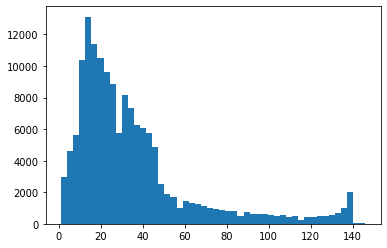

In [145]:
sen_len = []

for s in corpus:
    t = len(str(s))
    sen_len.append(t)

plt.figure()
plt.hist(sen_len, bins=50)

길이가 10미만인 문장과 길이가 50이상인 문장은 지워주도록 하겠습니다. 

In [146]:
max_len = 50
min_len = 10

filtered_corpus = [] 
filtered_target = []  

target = np.array(train_data['label'])

for s, t in zip(corpus, target):
    if (len(str(s)) < max_len) & (len(str(s)) >= min_len):
        filtered_corpus.append(s) 
        filtered_target.append(t)

print(len(filtered_corpus))
print(len(filtered_target))

109826
109826


이제 길이10~50인 말뭉치가 완성이 되었습니다.

# Step7. SentencePiece 모델 학습
토크나이저 함수를 정의해주기위해서 SentencePiece모델을 학습시켜줘야합니다.

In [147]:
import sentencepiece as spm

temp_file = '/content/drive/MyDrive/GoingDeeper_Data/GD1/korean-english-park.train.ko.temp'

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bpe_8k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)
)

In [148]:
!ls -l kor_spm_bpe_8k*

-rw-r--r-- 1 root root 408426 Sep 23 03:59 kor_spm_bpe_8k.model
-rw-r--r-- 1 root root 149617 Sep 23 03:59 kor_spm_bpe_8k.vocab


SentencePiece모델학습이 완료된후 **kor_spm_bpe_8k.model**파일과 **kor_spm_bpe_8k.vocab**파일이 생성되었음을 확인할 수 있습니다.

그럼 이렇게 학습된 모델을 한번 짧은 문장으로 활용해보겠습니다.

In [149]:
s = spm.SentencePieceProcessor()
s.Load('kor_spm_bpe_8k.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[6447, 1006, 8552, 8273, 1599, 8267, 8380, 8261, 8259]
아버지가방에들어가신다.


# Step8. Tokenizer 함수 작성
아래 조건을 만족하는 함수를 정의하도록 하겠습니다.
1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list를 전달합니다.
2. 생성된 vocab파일을 읽어와 {word:index}형태를 가지는 word_index사전과 {index:word}형태를 가지는 index_word사전을 생성하고 함께 반환합니다.
3. 리턴값인 tensor는 토큰화한 후 인코딩된 문장입니다. 

In [150]:
def sp_tokenize(s, corpus, spm):

    tensor = []
    
    # corpus에 있는 텍스트문장을 인코딩시켜 tensor에 넣어줍니다.
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    # 학습때 생성된 vocab파일을 불러와 vocab변수에 넣어 단어리스트를 생성합니다.
    with open("./{}.vocab".format(spm), 'r') as f:
        vocab = f.readlines() # vocab=[...,'▁어릴\t-995\n','▁역사\t-996\n',...]

    word_index = {}
    index_word = {}
    # vocab에 있는 단어를 꺼내 순수 텍스트만 꺼내서 word에 저장해주고, 이를 이용해 사전을 만들어줍니다.
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

그럼 말뭉치를 함수에 통과시켜서 tensor를 얻어봅시다.

In [151]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus, 'kor_spm_bpe_8k')

In [152]:
tensor[30]

array([   6,  208,   71,  245, 4574,  613,  539, 1019,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

# Step9. 훈련셋과 테스트셋 분리

In [155]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tensor, filtered_target, test_size=0.2)

In [165]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [158]:
print(len(X_train))
print(len(X_test))

87860
21966


# Step10. 모델설계 및 훈련

In [174]:
vocab_size = 10000
word_vector_dim = 200

lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

In [175]:
epochs = 20
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

lstm.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

lstm.fit(X_train, y_train,
         epochs=epochs,
         batch_size=512,
         validation_data=(X_test, y_test),
         callbacks=[callback],
         verbose=1)

Epoch 1/20
172/172 [==============================] - 3s 10ms/step - loss: 0.6932 - accuracy: 0.4944 - val_loss: 0.6931 - val_accuracy: 0.5035
Epoch 2/20
172/172 [==============================] - 1s 8ms/step - loss: 0.6931 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 3/20
172/172 [==============================] - 1s 8ms/step - loss: 0.6197 - accuracy: 0.6595 - val_loss: 0.6098 - val_accuracy: 0.6727
Epoch 4/20
172/172 [==============================] - 1s 8ms/step - loss: 0.5694 - accuracy: 0.7308 - val_loss: 0.5698 - val_accuracy: 0.7208
Epoch 5/20
172/172 [==============================] - 1s 8ms/step - loss: 0.5535 - accuracy: 0.7537 - val_loss: 0.5477 - val_accuracy: 0.7657
Epoch 6/20
172/172 [==============================] - 1s 8ms/step - loss: 0.5334 - accuracy: 0.7724 - val_loss: 0.5333 - val_accuracy: 0.7721
Epoch 7/20
172/172 [==============================] - 1s 8ms/step - loss: 0.4971 - accuracy: 0.7961 - val_loss: 0.5114 - val_accuracy: 0.7806
Epoch

# Step11. Unigram 사용
위에서 BPE모델을 사용해봤으니 이번엔 unigram모델을 사용해보겠습니다.

In [176]:
# unigram모델 학습

temp_file = '/content/drive/MyDrive/GoingDeeper_Data/GD1/korean-english-park.train.ko.temp'

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_unigram_10k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)
)

In [177]:
# unigram모델과 사전파일 확인
!ls -l kor_spm_unigram_10k*

-rw-r--r-- 1 root root 408431 Sep 23 05:26 kor_spm_unigram_10k.model
-rw-r--r-- 1 root root 149617 Sep 23 05:26 kor_spm_unigram_10k.vocab


In [179]:
# 텐서와 사전획득
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus, 'kor_spm_unigram_10k')

In [180]:
# 훈련셋과 테스트셋 분리
X_train, X_test, y_train, y_test = train_test_split(tensor, filtered_target, test_size=0.2)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [184]:
# 모델 설계
vocab_size = 10000
word_vector_dim = 200

lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

In [185]:
# 모델 학습
epochs = 20
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

lstm.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

lstm.fit(X_train, y_train,
         epochs=epochs,
         batch_size=512,
         validation_data=(X_test, y_test),
         callbacks=[callback],
         verbose=1)

Epoch 1/20
172/172 [==============================] - 3s 10ms/step - loss: 0.6933 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.4993
Epoch 2/20
172/172 [==============================] - 1s 8ms/step - loss: 0.6713 - accuracy: 0.5475 - val_loss: 0.5666 - val_accuracy: 0.7154
Epoch 3/20
172/172 [==============================] - 1s 8ms/step - loss: 0.5451 - accuracy: 0.7556 - val_loss: 0.6053 - val_accuracy: 0.6869
Epoch 4/20
172/172 [==============================] - 1s 8ms/step - loss: 0.5709 - accuracy: 0.7085 - val_loss: 0.5713 - val_accuracy: 0.7168
Epoch 5/20
172/172 [==============================] - 1s 8ms/step - loss: 0.5464 - accuracy: 0.7514 - val_loss: 0.5422 - val_accuracy: 0.7673
Epoch 6/20
172/172 [==============================] - 1s 8ms/step - loss: 0.5147 - accuracy: 0.7883 - val_loss: 0.5336 - val_accuracy: 0.7756
Epoch 7/20
172/172 [==============================] - 1s 8ms/step - loss: 0.4978 - accuracy: 0.8014 - val_loss: 0.5340 - val_accuracy: 0.7749
Epoch

# Step12. 성능 비교
모델 설계는 전부 동일하게 맞추어 진행하였고, 정확도순으로 표를 정리하였다.

|    |val_loss|val_accuracy|
|:---:|:---:|:---:|
|Mecab|0.3434|0.8502|
|Okt|0.3472|0.8459|
|BPE|0.4880|0.8212|
|unigram|0.4364|0.8137|

# 회고
- 이번 프로젝트는 여러가지 토크나이저를 사용해보면서 성능비교를하는 것입니다.
- 여기서 사용한 데이터셋은 네이버 영화 리뷰 데이터셋으로 예전에 사용해본적이있어, 전처리자체는 크게 어렵지 않았다.
- 초반에 Mecab을 사용하기위해 추가적인 설치과정이 있었다. 하지만 이 때문에 kkma랑 okt를 사용할때 에러가 나버린것이다. 에러를 해결하기위해 여러가지 시도를 해보고 구글링도 해보았지만, 아직 내 지식으로는 힘든것같아서 꼼수를 조금 써보았다. 먼저 Mecab을 사용한다음에, 세션관리에서 메로리를 지워서 초기화시켜주었다. 그리고나서 다시 KoNLPy를 불러와 Kkma와 Okt를 사용하였다.
- Kkma를 사용할때 또다른 문제가 발생했다... Kkma는 정확도가 높은대신 다른 토크나이저에 비해 매우 느린 단점이 있다. 그때문인지 연산도중에 서버의 메모리 용량을 초과해서 heap space에러가 발생했다. heap space size를 반복해서 늘려주었지만, 어디까지 늘려야되는지도 모르겠고 시간도 너무 많이 잡아먹었다. 하다보니까 굳이 이렇게까지해서 써봐야하나라는 현타가왔다... 어짜피 다른 토크나이저도 많이 써볼것인데..라는 생각에 그냥 Kkma사용은 안하기로했다.
- SentencePiece를 진행하기전에 데이터 전처리과정중에 너무 짧거나 너무 긴문장을 지우려고 len()을 사용해서 전처리를 하려했다. 하지만 왠지모르게 계속 에러가 뜨는것이 아닌가? 알고보니 당연히 전부 텍스트 데이터인줄알았는데 중간중간 텍스트가 아닌 숫자가 숨겨져있는것이었다. 그러니 len()함수가 안먹히는 것이 당연했다..
- SentencePiece 모델들은 사용하기가 매우 편리한것같다. 그냥 원래 텍스트 문장을 넣어주면, 인코딩을 거쳐 분산표현으로 출력이 되었다.
- SentencePiece모델들은 subword단위로 토큰화를 진행해 어떻게보면 Konlpy토크나이저보다 더 세밀하게 토큰화를 하는것이다. 하지만 최종 결과를 뽑아보니 SentencePiece모델보다 konlpy모델이 loss도 더 낮고, accuracy도 더 높았다. 엄청 큰차이가 나는것은 아니었지만, 딱히 이해가 가지않는다. 모델 설계를 잘못한것일까? 전처리를 잘못한것일까?